# Analyzing New York City Taxi Dataset (Batch)

## Dataset:
You can download the NYC taxi dataset from the link http://www.andresmh.com/nyctaxitrips/ then take
a sample from it. Each row of the file after the header represents a single taxi ride in CSV format. For
each ride, we have some attributes of the cab (a hashed version of the medallion number) as well as the
driver (a hashed version of the hack license, which is what licenses to drive taxis are called), some
temporal information about when the trip started and ended, and the longitude/latitude coordinates for
where the passenger(s) were picked up and dropped off.

### We are mainly interested in each Trip's:
- Some Unique ID for the car (license)
- Pick-up location
- Pick-up time
- Drop-off location
- Drop-off time

## Problem:

We need to compute one important statistic utilization. Utilization is the fraction of time that a cab is on
the road and is occupied by one or more passengers. One factor that impacts utilization is the
passenger's destination: a cab that drops off passengers near Union Square at midday is much more
likely to find its next fare in just a minute or two, whereas a cab that drops someone off at 2 AM on Staten Island may
have to drive all the way back to Manhattan before it find its next fare.
We need to compute:

1. The average time it takes for a taxi to find its next fare(trip) per destination borough,
2. The number of trips that started and ended within the same borough,
3. The number of trips that start in one borough and ended in another one

#### Import required packages

In [1]:
# import os
# import findspark

# os.environ["SPARK_HOME"] = "/opt/bitnami/hadoop/spark"
# findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, broadcast, unix_timestamp
from pyspark.sql.types import *
from shapely.geometry import shape, Point
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import json
import geopandas as gpd

#### Initiate spark session

In [3]:
spark = SparkSession \
    .builder \
    .appName("Taxi rides") \
    .getOrCreate()

### Preparing Taxi rides data

#### Read NYC Taxi rides data

In [4]:
rides = spark.read\
               .format("csv")\
               .option("header", "true")\
               .load("./sample_1000_records.csv")

In [5]:
rides.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_time_in_secs: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)



#### Convert datetime format to timestamp and calculate duration
Note: Duration already exists as "trip_time_in_secs"

In [6]:
rides = rides \
            .withColumn(
                'pickup_timestamp',
                unix_timestamp(rides.pickup_datetime)
            ).withColumn(
                'dropoff_timestamp',
                unix_timestamp(rides.dropoff_datetime)
            ).withColumn(
                'duration',
                unix_timestamp(rides.dropoff_datetime) - unix_timestamp(rides.pickup_datetime)
            )

#### Drop unwanted columns

In [7]:
rides = rides.drop(
    'medallion',
    'vendor_id',
    'rate_code',
    'store_and_fwd_flag',
    'passenger_count',
    'trip_distance',
    'pickup_datetime',
    'dropoff_datetime',
    'trip_time_in_secs'
)

#### Filter for duration more than 0 and less than 4 hours (4\*60\*60 = 14400)

In [8]:
rides = rides.filter('duration > "0" and duration < "14400"')

#### Sort by "hack_license" to make sure that all taxi driver data be available at the same cluster

In [9]:
rides = rides.sort(rides.hack_license, rides.pickup_timestamp)

In [10]:
rides.show(5)

rides.count()

+--------------------+----------------+---------------+-----------------+----------------+----------------+-----------------+--------+
|        hack_license|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|pickup_timestamp|dropoff_timestamp|duration|
+--------------------+----------------+---------------+-----------------+----------------+----------------+-----------------+--------+
|00567B1CBFD51DDFA...|        -73.9729|      40.795914|       -73.996353|       40.753288|      1358074800|       1358075760|     960|
|00711D0CC3FB5BC90...|      -73.989761|      40.723213|       -74.022575|       40.622131|      1358051280|       1358052300|    1020|
|00BF52E4A8E6DBB01...|      -73.954803|      40.769821|       -73.946419|       40.781841|      1358072100|       1358072280|     180|
|01202D837DD4454C7...|      -73.958099|      40.815384|       -73.958054|        40.81543|      1358052300|       1358052420|     120|
|015760806341352ED...|      -74.003059|      40.723473|

996

### Preparing borough geospatial data

#### Read borough geospatial data as Json

In [11]:
boroughsPolygon = json.load(open('./nyc-boroughs.geojson'))['features']

#### Convert borough Json to Dataframe

In [12]:
schema = StructType([
    StructField("geometry", StructType([
        StructField("coordinates", ArrayType(ArrayType(ArrayType(FloatType())))),
        StructField("type", StringType()),
    ])),
    StructField("properties", StructType([
        StructField("@id", StringType()),
        StructField("borough", StringType()),
        StructField("boroughCode", IntegerType()),
    ])),
    StructField("id", IntegerType()),
    StructField("type", StringType()),
])
sparkBoroughsPolygon = spark.createDataFrame(boroughsPolygon, schema)

#### Create UDF (User Defined Function) to get Polygon area

In [13]:
add_polygon_area_udf = udf(
    lambda geometry: shape({"coordinates": geometry['coordinates'], "type": geometry['type']}).area
)

#### Add area as column and another columns to simplify the usage of this DF (DataFrame)

In [14]:
sparkBoroughsPolygon = sparkBoroughsPolygon \
                            .withColumn(
                                "area",
                                add_polygon_area_udf(sparkBoroughsPolygon.geometry).cast(FloatType())
                            ).withColumn(
                                "borough",
                                sparkBoroughsPolygon.properties['borough']
                            ).withColumn(
                                "boroughCode",
                                sparkBoroughsPolygon.properties['boroughCode']
                            )

#### Drop unwanted columns

In [15]:
sparkBoroughsPolygon = sparkBoroughsPolygon.drop(
    'properties',
    'type',
    'id'
)

#### Sort by "area" to simplify the search in the boroughs by making the biggest on the top

In [16]:
sparkBoroughsPolygon = sparkBoroughsPolygon.sort(
    sparkBoroughsPolygon.area.desc(),
    sparkBoroughsPolygon.boroughCode.desc()
)

In [17]:
sparkBoroughsPolygon.show(5)

+--------------------+------------+-------------+-----------+
|            geometry|        area|      borough|boroughCode|
+--------------------+------------+-------------+-----------+
|[[[[-73.89145, 40...| 0.027193693|       Queens|          4|
|[[[[-73.9544, 40....| 0.018705718|     Brooklyn|          3|
|[[[[-74.082214, 4...| 0.016035538|Staten Island|          5|
|[[[[-73.87295, 40...| 0.011405894|        Bronx|          2|
|[[[[-73.92641, 40...|0.0058590746|    Manhattan|          1|
+--------------------+------------+-------------+-----------+
only showing top 5 rows



#### Plot the boroughs using GeoPandas

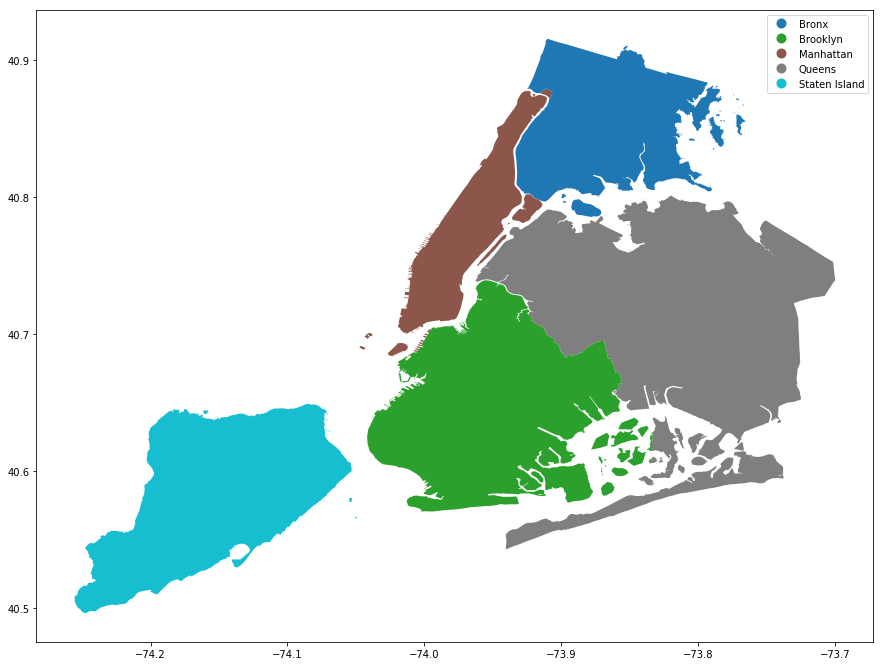

In [36]:
boroughs = gpd.read_file('./nyc-boroughs.geojson')
boroughs.plot(column='borough', legend=True, figsize=(15, 15))

### Enrich rides Data by boroughs name using the geospatial data for each ride

#### Create UDF (User Defined Function) to check if Point (long, lat) in Polygon (borough)

In [19]:
point_within_polygon_udf = udf(
    lambda long, lat, geometry: Point(float(long), float(lat)) \
                                    .within(shape({
                                        "coordinates": geometry['coordinates'],
                                        "type": geometry['type']
                                    }))
)

#### Broadcast boroughs table in order to be available for all clusters and tasks.

In [20]:
broadcastedSparkBoroughsPolygon = broadcast(sparkBoroughsPolygon)

#### Enable "crossJoin"

In [21]:
spark.conf.set("spark.sql.crossJoin.enabled", True)

#### Joining to get the pickup borough name

In [22]:
rides = rides.join(
        broadcastedSparkBoroughsPolygon,
        on=point_within_polygon_udf(
            rides.pickup_longitude,
            rides.pickup_latitude,
            broadcastedSparkBoroughsPolygon.geometry
        ).cast(BooleanType())) \
    .select(rides.columns + [broadcastedSparkBoroughsPolygon.borough.alias('pickup_borough')])

#### Joining to get the dropoff borough name

In [23]:
rides = rides.join(
        broadcastedSparkBoroughsPolygon,
        on=point_within_polygon_udf(
            rides.dropoff_longitude,
            rides.dropoff_latitude,
            broadcastedSparkBoroughsPolygon.geometry
        ).cast(BooleanType())) \
    .select(rides.columns + [broadcastedSparkBoroughsPolygon.borough.alias('dropoff_borough')])

#### Drop unwanted columns

In [24]:
rides = rides.drop(
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
)

In [25]:
rides.show(5)

+--------------------+----------------+-----------------+--------+--------------+---------------+
|        hack_license|pickup_timestamp|dropoff_timestamp|duration|pickup_borough|dropoff_borough|
+--------------------+----------------+-----------------+--------+--------------+---------------+
|00567B1CBFD51DDFA...|      1358074800|       1358075760|     960|     Manhattan|      Manhattan|
|00711D0CC3FB5BC90...|      1358051280|       1358052300|    1020|     Manhattan|       Brooklyn|
|00BF52E4A8E6DBB01...|      1358072100|       1358072280|     180|     Manhattan|      Manhattan|
|01202D837DD4454C7...|      1358052300|       1358052420|     120|     Manhattan|      Manhattan|
|015760806341352ED...|      1357510702|       1357511211|     509|     Manhattan|      Manhattan|
+--------------------+----------------+-----------------+--------+--------------+---------------+
only showing top 5 rows



### Get the Utilization by calculating the idle time between two rides

#### Create window that contains 2 records per Taxi Driver (prev record, current record)

In [26]:
windowSpec = Window \
                .partitionBy(rides.hack_license) \
                .rowsBetween(-1, 0)

#### Calculate the idle time then persist the data in order to use it agan in the tasks without compute it again

In [27]:
rides = rides.withColumn(
    'idle_time',
     rides.pickup_timestamp - func.min(rides.pickup_timestamp).over(windowSpec)
).persist()

In [28]:
rides.show(10)

+--------------------+----------------+-----------------+--------+--------------+---------------+---------+
|        hack_license|pickup_timestamp|dropoff_timestamp|duration|pickup_borough|dropoff_borough|idle_time|
+--------------------+----------------+-----------------+--------+--------------+---------------+---------+
|980A15AE7BF88E611...|      1358052240|       1358052960|     720|     Manhattan|      Manhattan|        0|
|A169B687A86BDE3FE...|      1358072820|       1358073060|     240|     Manhattan|      Manhattan|        0|
|C4BCB67BB39AD8C17...|      1358074740|       1358075400|     660|     Manhattan|      Manhattan|        0|
|F41C758E0A9022F59...|      1358074980|       1358075580|     600|     Manhattan|      Manhattan|        0|
|FA36E516BD1822D19...|      1358072820|       1358073180|     360|     Manhattan|      Manhattan|        0|
|0B6E99C5380BF98FA...|      1358072880|       1358073120|     240|     Manhattan|      Manhattan|        0|
|4A6C8D08FAB98E9C9...|      

## Task 1:
### Avarage idle time per destination borough

In [29]:
avg_idle_time_per_dest_borough = rides.where('idle_time < "14400"') \
                                    .groupBy('dropoff_borough')\
                                    .agg({'idle_time':"avg"}) \
                                    .withColumnRenamed('avg(idle_time)', 'avg_idle_time')

In [30]:
avg_idle_time_per_dest_borough.show()

+---------------+------------------+
|dropoff_borough|     avg_idle_time|
+---------------+------------------+
|         Queens| 84.63636363636364|
|       Brooklyn|201.11494252873564|
|      Manhattan| 312.4173126614987|
|          Bronx|               0.0|
+---------------+------------------+



## Task 2:
### Number of trips that started and ended within the same borough

In [31]:
no_rides_within_same_borough = rides.where('pickup_borough == dropoff_borough') \
                                    .count()

In [32]:
no_rides_within_same_borough

790

## Task 3:
### Number of trips that started and ended in another borough

In [33]:
no_rides_ended_in_another_borough = rides.where('(pickup_borough != dropoff_borough) and dropoff_borough is NOT Null') \
                                        .count()

In [34]:
no_rides_ended_in_another_borough

183

## Unpersist the data and close the Spark session

In [35]:
rides.unpersist()
sparkBoroughsPolygon.unpersist()
broadcastedSparkBoroughsPolygon.unpersist()
avg_idle_time_per_dest_borough.unpersist()

spark.stop()